<a href="https://colab.research.google.com/github/mariamihaila/Book-Recommendation-System/blob/main/Book_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Academic Book Recommendation System 
#### Dataset of 10,000 Books From Eight Top Academic Publishers
#### Content - Based  Recommendation System using TF-IDF







### Load the goodreads data as a panda series dataframe


In [1]:
import pandas as pd
from rake_nltk import Rake
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import warnings

from textblob import TextBlob
from textblob import Word

import seaborn as sns

import re
warnings.filterwarnings("ignore")
books = pd.DataFrame(columns = pd.read_csv('/Users/mariamihaila/Downloads/goodreads/book1000k-1100k.csv', index_col = 'Id').columns)
books

,Name,Authors,ISBN,Rating,PublishYear,PublishMonth,PublishDay,Publisher,RatingDist5,RatingDist4,RatingDist3,RatingDist2,RatingDist1,RatingDistTotal,CountsOfReview,Language,pagesNumber,Description,Count of text reviews


In [2]:
import os
for dirname, _, filenames in os.walk('/Users/mariamihaila/Downloads/goodreads/'):
    for filename in filenames:
        if "_" not in filename:
            books = pd.concat([books, pd.read_csv(os.path.join(dirname, filename), index_col = 'Id')])
            print(os.path.join(dirname, filename), 'OK')


/Users/mariamihaila/Downloads/goodreads/book1900k-2000k.csv OK
/Users/mariamihaila/Downloads/goodreads/book1600k-1700k.csv OK
/Users/mariamihaila/Downloads/goodreads/book700k-800k.csv OK
/Users/mariamihaila/Downloads/goodreads/book600k-700k.csv OK
/Users/mariamihaila/Downloads/goodreads/book1000k-1100k.csv OK
/Users/mariamihaila/Downloads/goodreads/book100k-200k.csv OK
/Users/mariamihaila/Downloads/goodreads/book1300k-1400k.csv OK
/Users/mariamihaila/Downloads/goodreads/book1500k-1600k.csv OK
/Users/mariamihaila/Downloads/goodreads/book1200k-1300k.csv OK
/Users/mariamihaila/Downloads/goodreads/book800k-900k.csv OK
/Users/mariamihaila/Downloads/goodreads/book2000k-3000k.csv OK
/Users/mariamihaila/Downloads/goodreads/book400k-500k.csv OK
/Users/mariamihaila/Downloads/goodreads/book1700k-1800k.csv OK
/Users/mariamihaila/Downloads/goodreads/book1800k-1900k.csv OK
/Users/mariamihaila/Downloads/goodreads/book200k-300k.csv OK
/Users/mariamihaila/Downloads/goodreads/book500k-600k.csv OK
/Users

## Exploratory Data Analysis 


### Feature Extraction: 

In [3]:
books.head()

,Name,Authors,ISBN,Rating,PublishYear,PublishMonth,PublishDay,Publisher,RatingDist5,RatingDist4,RatingDist3,RatingDist2,RatingDist1,RatingDistTotal,CountsOfReview,Language,pagesNumber,Description,Count of text reviews,PagesNumber
1900511,Barbarossa,Christopher Ailsby,1840138009,3.0,2007,4,1,New Line Books,5:0,4:0,3:1,2:0,1:0,total:1,0,NaN,NaN,"On 22 June 1941, Adolf Hitler launched Operati...",NaN,192.0
1900512,Collector's Guide to German World War II: Comb...,Christopher Ailsby,0781802253,0.0,1994,7,1,Hippocrene Books,5:0,4:0,3:0,2:0,1:0,total:0,0,NaN,NaN,NaN,NaN,160.0
1900514,Images of Barbarossa,Christopher Ailsby,0711028257,3.5,2001,1,25,Ian Allan Ltd,5:0,4:5,3:2,2:1,1:0,total:8,0,NaN,NaN,"On 22 June 1941, Adolf Hitler launched Operati...",NaN,256.0
1900520,Romania After 2000: Five New Romanian Plays,Daniel Charles Gerould,0595436560,4.0,2007,9,1,Martin E. Segal Theatre Center Publications,5:1,4:4,3:1,2:0,1:0,total:6,0,NaN,NaN,The first anthology of new Romanian Drama publ...,NaN,226.0
1900521,Global Foreigners: An Anthology of Plays,Saviana Stănescu,1905422423,4.6,2006,12,7,Seagull Books,5:4,4:0,3:1,2:0,1:0,total:5,0,NaN,NaN,"In Waxing West, Daniella, newly arrived in the...",NaN,320.0


How many unique book title are there? 


>  Answer: 1636235




In [4]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1850310 entries, 1900511 to 1499999
Data columns (total 20 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Name                   object 
 1   Authors                object 
 2   ISBN                   object 
 3   Rating                 float64
 4   PublishYear            object 
 5   PublishMonth           object 
 6   PublishDay             object 
 7   Publisher              object 
 8   RatingDist5            object 
 9   RatingDist4            object 
 10  RatingDist3            object 
 11  RatingDist2            object 
 12  RatingDist1            object 
 13  RatingDistTotal        object 
 14  CountsOfReview         object 
 15  Language               object 
 16  pagesNumber            object 
 17  Description            object 
 18  Count of text reviews  object 
 19  PagesNumber            float64
dtypes: float64(2), object(18)
memory usage: 296.5+ MB


In [5]:
books['Name'].nunique()

1636235

How many books are in the dataset? 


> Answer: 1850310

This means that some of the books are probably duplicates of eachother, possibly different editions. Let's remove all the title duplicates. 



In [6]:
len(books['Name'])

1850310

### Remove duplicate books from the dataset



In [7]:
books.sort_index(inplace = True)


In [8]:
# extract duplicate rows
books.loc[books.Name.duplicated(), :]
# drop the duplicate books from the data set
books.drop_duplicates(subset = ['Name'], inplace = True)

Make sure the duplicate drop was succesful: 

In [9]:
(books.Name.duplicated()).sum()

0

In [10]:
len(books['Name'])

1636235

### Remove books with no description
Check for null values. We see that there are quite a few entries with data missing. For the sake of accurate reccomendation, I will remove the 679122 books that are missing a description. 

In [11]:
books.isnull().sum()

Name                           0
Authors                        0
ISBN                        5013
Rating                         0
PublishYear                    0
PublishMonth                   0
PublishDay                     0
Publisher                  16634
RatingDist5                    0
RatingDist4                    0
RatingDist3                    0
RatingDist2                    0
RatingDist1                    0
RatingDistTotal                0
CountsOfReview                 0
Language                 1425579
pagesNumber               881824
Description               638645
Count of text reviews    1282821
PagesNumber               754411
dtype: int64

In [12]:
books[books['Description'].isnull()].head()

,Name,Authors,ISBN,Rating,PublishYear,PublishMonth,PublishDay,Publisher,RatingDist5,RatingDist4,RatingDist3,RatingDist2,RatingDist1,RatingDistTotal,CountsOfReview,Language,pagesNumber,Description,Count of text reviews,PagesNumber
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,NaN,4.57,2006,16,9,Scholastic Inc.,5:1546466,4:556485,3:159960,2:25317,1:9896,total:2298124,28062,eng,652,NaN,NaN,NaN
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,0439358078,4.50,2004,1,9,Scholastic Inc.,5:1493113,4:604283,3:211781,2:37005,1:12455,total:2358637,29770,eng,870,NaN,NaN,NaN
3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,NaN,4.47,2003,1,11,Scholastic Inc,5:4268227,4:1513191,3:567458,2:130310,1:108202,total:6587388,75911,eng,309,NaN,NaN,NaN
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,0439554896,4.42,2003,1,11,Scholastic,5:1504505,4:706082,3:288821,2:49353,1:11896,total:2560657,244,eng,352,NaN,NaN,NaN
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,043965548X,4.57,2004,1,5,Scholastic Inc.,5:1749958,4:630534,3:194848,2:24849,1:10128,total:2610317,37093,eng,435,NaN,NaN,NaN


In [13]:
books.dropna(subset = ['Description'], inplace = True)

In [14]:
# check to see if succesful
books.Description.isnull().sum()

0

### Data Visualization: 


#### Top 10 Publishers:
- Springer Publishing is an American publishing company of academic journals and books, focusing on the fields of nursing, gerontology, psychology, social work, counseling, public health, and rehabilitation. Wikipedia
- Routledge is a British multinational publisher. It was founded in 1836 by George Routledge, and specialises in providing academic books, journals and online resources in the fields of humanities, behavioural science, education, law, and social science. Wikipedia
- Peter Lang is an academic publisher specializing in the humanities and social sciences. It has its headquarters in Pieterlen and Bern, Switzerland, with offices in Brussels, Frankfurt am Main, New York City, Dublin, Oxford, Vienna, and Warsaw. Wikipedia
- The CRC Press, LLC is an American publishing group that specializes in producing technical books. Many of their books relate to engineering, science and mathematics. Their scope also includes books on business, forensics and information technology. Wikipedia
- John Wiley & Sons, Inc., commonly known as Wiley, is an American multinational publishing company founded in 1807 that focuses on academic publishing and instructional materials. Wikipedia


... with the exception of iUniverse and Kessinger Press, all the publishing houses mentioned are academic. My plan is to keep only the books published by the top 8 academic publishing houses, and drop everything else. Then, sorting in descending order by popularity (measured by number of reviews), I take the top 20,000 books to become part of the final dataset. 

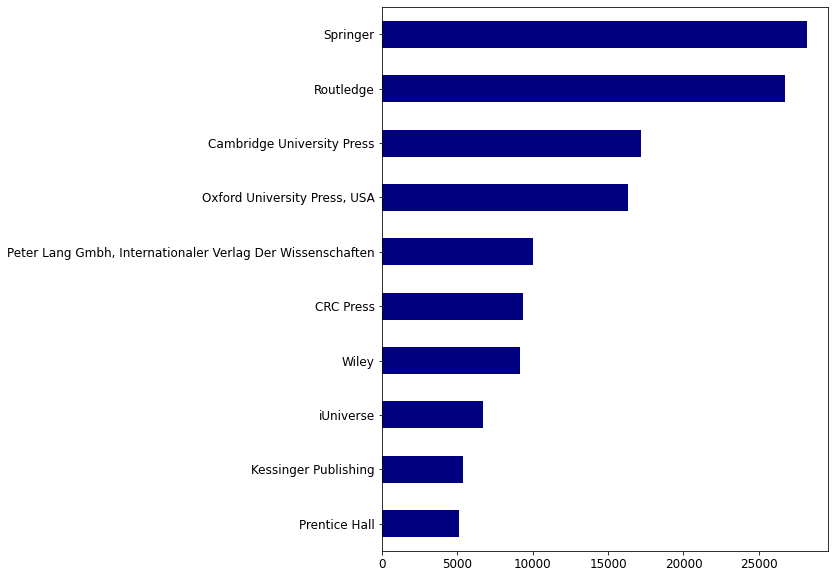

In [15]:
books['Publisher'].value_counts()[0 : 10].plot(kind = 'barh', figsize = [8,10],fontsize=12, color='navy').invert_yaxis()

In [26]:

# find the top 8 academic publishing houses (so not  iUniverse and Kessinger Publishing)
books['Publisher'].value_counts()[:8]
top_8_publishers = ['Springer', 'Routledge', 'Cambridge University Press', 
                           'Oxford University Press, USA', 'Peter Lang Gmbh, Internationaler Verlag Der Wissenschaften', 
                           'CRC Press', 'Wiley', 'Prentice Hall']


# make seperate dataframes for each publishing house
Springer = books.loc[books['Publisher'] == top_8_publishers[0]]
Routledge = books.loc[books['Publisher'] == top_8_publishers[1]]
Cambridge = books.loc[books['Publisher'] == top_8_publishers[2]]
Oxford = books.loc[books['Publisher'] == top_8_publishers[3]]
Peter_lang = books.loc[books['Publisher'] == top_8_publishers[4]]
CRC_Press = books.loc[books['Publisher'] == top_8_publishers[5]]
Wiley = books.loc[books['Publisher'] == top_8_publishers[6]]
Prentice_Hall = books.loc[books['Publisher'] == top_8_publishers[7]]

df_list = [Springer, Routledge, Cambridge, Oxford, Peter_lang, CRC_Press, Wiley, Prentice_Hall]


top_books = pd.DataFrame()
# sort books by popularity (popularity measured by CountsOfReview) for each df
for df in df_list:
  df.sort_values(by = ['CountsOfReview'], ascending = False, inplace = True)
  df.reset_index(inplace= True)
  # merge top 1,250 books of each df into a new df: top_books
  top_books = top_books.append(df[:1250])
top_books.reset_index(inplace= True)

## Data preprocessing

using regex,nltk and beautifulsoup
- convert all text to lowercase 
- remove white space from description
- remove punctuation from description
- remove all links
- remove stop words from description
- lemmatize words in description (convert all words to their root)

TIPS: make a copy of the dataframe because you WILL inevitably mess up with regex and have to rerun everything. 


In [31]:
# make a copy of the dataframe for when I inevitably will mess up
df = pd.DataFrame()
df['Description'] = top_books['Description']

In [32]:
# remove html tags

from bs4 import BeautifulSoup

def remove_html_tags(df):
  for index, row in df.iterrows():
    text = df['Description'][index]
    soup = BeautifulSoup(text, "html.parser")
    for data in soup([['style', 'script']]):
      data.decompose()
    cleaned = ' '.join(soup.stripped_strings)
    df['Description'][index] = cleaned
  return df

df = remove_html_tags(df)


In [33]:
# remove punctuation
df['Description'] = df['Description'].str.replace('[^\w\s]','')


In [34]:
punctuation_removed_test = df['Description'][4]
print("original description: ", top_books['Description'][4], '\n')
print("punctuation removed: ", punctuation_removed_test)

original description:  This text provides examples from contemporary and historical scientific presentations to show clearly what makes an oral presentation effective. It considers presentations made to persuade an audience to adopt some course of action (such as funding a proposal) as well as presentations made to communicate information, and it considers these from four perspectives: speech, structure, visual aids, and delivery. 

punctuation removed:  This text provides examples from contemporary and historical scientific presentations to show clearly what makes an oral presentation effective It considers presentations made to persuade an audience to adopt some course of action such as funding a proposal as well as presentations made to communicate information and it considers these from four perspectives speech structure visual aids and delivery


In [35]:
# remove stop words
stop = stopwords.words('english')
df['Description'] = df['Description'].astype(str).apply(lambda x: " ".join(x for x in x.split() if x not in stop))


In [36]:
stopwords_removed_test = df['Description'][14]
print("o.g: ", top_books['Description'][14])
print("stopwords_removed_test: ", stopwords_removed_test)

o.g:  At last, Raymond Calvel's Le Gout du Pain is available in English, translated by Ronald Wirtz. Mr. Calvel is known throughout the world for his research on the production of quality French and European hearth breads.<br /><br />The Taste of Bread is a thorough guide to the elements and principles behind the production of good-tasting bread, including a broad variety of bread products as flavored breads, breadsticks, croissants, brioches, and other regional baked goods. Each important aspect of the process is covered:<br /><br />wheat and milling<br />characteristics of breadmaking flour<br />dough composition<br />oxidation in the mixing process<br />leavening and fermentation<br />effects of dough division and formation<br />baking and equipment<br />storage<br /><br />The English edition provides notes and information specifically on the use of North American flours and includes recipes in both metric and US units. Enhanced with new black-and-white and color photography, The Ta

In [37]:
# convert text to lowercase
df['Description'] = df['Description'].astype(str).str.lower() 

In [38]:
lowercase_conversion_test = df['Description'][100]
print("o.g: ", top_books['Description'][100], '\n')
print("lowercase test: ", lowercase_conversion_test)

o.g:  In the summer and autumn of 2006 I read several interviews with Brian May in which he mentioned his desire to complete the PhD that he had abandoned in 1974. I looked up the papers he had published while a PhD student, which were on spectroscopic studies of the motion of the dust responsible for the zodiacal light, and felt that there was a basis for a thesis. Since he had been a student at Imperial, I knew, as Head of the Astrophysics Group at Imperial, that it would be good for the Group if he came and worked with us. I got in touch with him by email and suggested he come and talk about it. He replied enthusiastically and said that he was working on typing up what he had completed by 1974. I gradually realized that I was the only staff member at Imperial who had previously worked on zodiacal dust, so that I would have to act as his supervisor. Eventually we met and I tried to assess whether he would be able to find time for the huge amount of work that finishing off a thesis in

In [ ]:
# lemmatizing - convert all words to their root. This will take some time.

nltk.download('wordnet')
df['Description'] = df['Description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['Description'].head()

In [39]:
lemmatized_test = df['Description'][800]
print("o.g: ", top_books['Description'][800], '\n')
print("lemmatized test: ", lemmatized_test)


o.g:  This work sounds an early warning about an environmental catastrophe that has become all too familiar today - the invasion of nonnative species. The author explains the devastating effects that invasive species can have on local ecosystems. 

lemmatized test:  this work sounds early warning environmental catastrophe become familiar today invasion nonnative species the author explains devastating effects invasive species local ecosystems


In [40]:
# make sure df, the dataframe copy, is still intact
df['Description']

0       between 1968 1972 twenty four daring men journ...
1       this edition organized six parts theoretical c...
2       this book already translated ten languages may...
3       this book outlines elementary onesemester cour...
4       this text provides examples contemporary histo...
                              ...                        
9995    to equip prospective educational leaders under...
9996    headed bestseller lists fall allnew advice tur...
9997    this innovative text simplifies process choosi...
9998    the linux az guides computer literate student ...
9999    designed improve skills assessing managing ext...
Name: Description, Length: 10000, dtype: object

In [57]:
# now replace books['Description'] with the cleaned df['Description']
# actually to play it safe ... make a new column.  
top_books['Description_cleaned'] = df['Description']
top_books

,level_0,index,Name,Authors,ISBN,Rating,PublishYear,PublishMonth,PublishDay,Publisher,...,RatingDist1,RatingDistTotal,CountsOfReview,Language,pagesNumber,Description,Count of text reviews,PagesNumber,Description_cleaned,text
0,0,2323178,How Apollo Flew to the Moon,W. David Woods,0387716750,4.63,2008,1,8,Springer,...,1:2,total:399,33,eng,NaN,"Between 1968 and 1972, twenty four daring men ...",NaN,412.0,between 1968 1972 twenty four daring men journ...,W. David Woods Springer between 1968 1972 twen...
1,1,3216708,Concise Inorganic Chemistry,J.D. Lee,0412788209,4.08,1996,12,15,Springer,...,1:27,total:370,17,NaN,NaN,This edition is organized into six parts: theo...,NaN,1032.0,this edition organized six parts theoretical c...,J.D. Lee Springer this edition organized six p...
2,2,3224638,The Buzz about Bees: Biology of a Superorganism,Jürgen Tautz,3540787275,4.54,2008,8,1,Springer,...,1:0,total:141,15,NaN,NaN,"This book, already translated into ten languag...",NaN,284.0,this book already translated ten languages may...,Jürgen Tautz Springer this book already transl...
3,3,845794,Understanding Analysis,Stephen Abbott,0387950605,4.34,2002,12,7,Springer,...,1:4,total:226,15,NaN,260,"This book outlines an elementary, one-semester...",15,NaN,this book outlines elementary onesemester cour...,Stephen Abbott Springer this book outlines ele...
4,4,874421,The Craft of Scientific Presentations: Critica...,Michael Alley,0387955550,3.91,2007,1,8,Springer,...,1:1,total:89,10,NaN,241,This text provides examples from contemporary ...,10,NaN,this text provides examples contemporary histo...,Michael Alley Springer this text provides exam...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1245,3236938,Practicing the Art of Leadership: A Problem-Ba...,Reginald Leon Green,0131599739,3.55,2008,2,1,Prentice Hall,...,1:0,total:22,0,NaN,NaN,To equip prospective educational leaders to un...,NaN,266.0,to equip prospective educational leaders under...,Reginald Leon Green Prentice Hall to equip pro...
9996,1246,3236155,Sylvia Porter's Your Finances in the 1990s,Sylvia Field Porter,0138797765,0.00,1990,10,1,Prentice Hall,...,1:0,total:0,0,NaN,NaN,Headed for bestseller lists this fall: all-new...,NaN,346.0,headed bestseller lists fall allnew advice tur...,Sylvia Field Porter Prentice Hall headed bests...
9997,1247,3235748,Selecting a College Major: Exploration and Dec...,Virginia N. Gordon,0130395854,3.00,2003,2,14,Prentice Hall,...,1:1,total:4,0,NaN,NaN,This innovative text simplifies the process of...,NaN,107.0,this innovative text simplifies process choosi...,Virginia N. Gordon Prentice Hall this innovati...
9998,1248,3229391,The Linux A-Z: A Complete Guide to Linux for A...,Philip Cornes,0132347091,4.00,1996,10,31,Prentice Hall,...,1:0,total:1,0,NaN,NaN,The LINUX A-Z guides the computer literate stu...,NaN,576.0,the linux az guides computer literate student ...,Philip Cornes Prentice Hall the linux az guide...


### Create the book corpus 
combine the author, published and cleaned description columns

In [74]:
top_books['text'] = top_books['Authors'].map(str) + ' ' + top_books['Publisher'] + ' ' + top_books['Description_cleaned']

In [75]:
books_corpus = top_books[['Name', 'ISBN','text']]
books_corpus = books_corpus.fillna(" ")
books_corpus['text'] = books_corpus['text'].astype(str).str.lower() # convert everything to lowercase
books_corpus['text'] = books_corpus['text'].str.replace('[^\w\s]','') # remove punctuation

In [76]:
books_corpus

,Name,ISBN,text
0,How Apollo Flew to the Moon,0387716750,w david woods between 1968 1972 twenty four da...
1,Concise Inorganic Chemistry,0412788209,jd lee this edition organized six parts theore...
2,The Buzz about Bees: Biology of a Superorganism,3540787275,jürgen tautz this book already translated ten ...
3,Understanding Analysis,0387950605,stephen abbott this book outlines elementary o...
4,The Craft of Scientific Presentations: Critica...,0387955550,michael alley this text provides examples cont...
...,...,...,...
9995,Practicing the Art of Leadership: A Problem-Ba...,0131599739,reginald leon green to equip prospective educa...
9996,Sylvia Porter's Your Finances in the 1990s,0138797765,sylvia field porter headed bestseller lists fa...
9997,Selecting a College Major: Exploration and Dec...,0130395854,virginia n gordon this innovative text simplif...
9998,The Linux A-Z: A Complete Guide to Linux for A...,0132347091,philip cornes the linux az guides computer lit...


In [77]:
# DONT FORGET TO SAVE THE CLEANED DATA
compression_opts = dict(method='zip', archive_name='top_books.csv')  
books_corpus.to_csv('top_books.zip', index=False, compression=compression_opts) 

## Time for TF-IDF

In [80]:
import pandas as pd

# load the cleaned dataset
books_corpus = pd.read_csv('top_books 2.csv')
books_corpus

,Name,ISBN,text
0,How Apollo Flew to the Moon,0387716750,w david woods between 1968 1972 twenty four da...
1,Concise Inorganic Chemistry,0412788209,jd lee this edition organized six parts theore...
2,The Buzz about Bees: Biology of a Superorganism,3540787275,jürgen tautz this book already translated ten ...
3,Understanding Analysis,0387950605,stephen abbott this book outlines elementary o...
4,The Craft of Scientific Presentations: Critica...,0387955550,michael alley this text provides examples cont...
...,...,...,...
9995,Practicing the Art of Leadership: A Problem-Ba...,0131599739,reginald leon green to equip prospective educa...
9996,Sylvia Porter's Your Finances in the 1990s,0138797765,sylvia field porter headed bestseller lists fa...
9997,Selecting a College Major: Exploration and Dec...,0130395854,virginia n gordon this innovative text simplif...
9998,The Linux A-Z: A Complete Guide to Linux for A...,0132347091,philip cornes the linux az guides computer lit...


In [81]:
#initializing tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_books = tfidf_vectorizer.fit_transform((books_corpus['text'][:10000])) 
tfidf_books

<10000x83155 sparse matrix of type '<class 'numpy.float64'>'
	with 724676 stored elements in Compressed Sparse Row format>

## Build the recommendation system!

- compute cosine similarity using tfidf
- the recommendation function:

    *    get index of the user inputted book title
    *    search cosine similarity matrix, sorting the similarity values in descending order
    * return a list of the top 5 most similar books
    




In [82]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_books)

In [83]:
cosine_sim.shape

(10000, 10000)

In [121]:
 indices = pd.Series(books_corpus['Name'])

 def recommend(title, cosine_sim = cosine_sim):
    recommended_books = []
    idx = indices[indices == title].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)   # similarity scores in descending order
    top_5_indices = list(score_series.iloc[1:6].index)   # to get the indices of top 10 most similar books
    print("finding reccs for: ", title, "Description : ", books_corpus['text'][idx])

    for i in top_5_indices:   
        recommended_books.append(list(books_corpus['Name'])[i])
        print(books_corpus['Name'][i], "Description : ", books_corpus['text'][i], '\n') 
        # remember that the description has stop words and punctuation removed and printing it out is just 
        # for evaluation purposes
    return recommended_books

In [122]:
recommend('The Buzz about Bees: Biology of a Superorganism')

finding reccs for:  The Buzz about Bees: Biology of a Superorganism Description :  jürgen tautz this book already translated ten languages may frst sight appear honeybees biology it contains however number deeper messages related basic important principles modern biology the bees merely actors take us realm physiology genetics reproduction biophysics learning introduce us principles natural selection underlying evolution simple complex life forms the book destroys cute notion bees anthropomorphic icons busy selfsacrificing individuals presents us reality colony integrated independent beinga superorganism almost eerie emergent group intelligence we surprised learn single bee queen drone sterile worker oversight control colony instead network integrated control systems feedbacks communication individuals colony arrives consensus decisions bottom type swarm intelligence indeed remarkable parallels functional organization swarming honeybee colony vertebrate brains
Biology for Engineers Des

['Biology for Engineers',
 'Evolution of Life Histories: Theory and Analysis',
 'Computational Intelligence: An Introduction',
 'Biochemistry & Molecular Biology of Plants',
 'Control Systems Engineering']

In [123]:
recommend('Understanding Analysis')

finding reccs for:  Understanding Analysis Description :  stephen abbott this book outlines elementary onesemester course exposes students process rigor rewards inherent taking axiomatic approach study functions real variable the aim course real analysis challenge improve mathematical intuition rather verify the philosophy book focus attention questions give analysis inherent fascination
Analysis With An Introduction To Proof Description :  steven r lay carefully focused reading writing proofs introduction analysis functions single real variable helps readers transition computationally oriented abstract mathematics it features clear expositions examples helpful practice problems many drawings illustrate key ideas hintsanswers selected problems logic proof sets functions the real numbers sequences limits continuity differentiation integration infinite series sequences series functions for anyone interested real analysis advanced calculus 

Real Analysis and Foundations Description :  st

['Analysis With An Introduction To Proof',
 'Real Analysis and Foundations',
 'Lectures on the Hyperreals: An Introduction to Nonstandard Analysis',
 'Introduction to Analysis of the Infinite: Book I',
 'Appraisal, Market Analysis and Public Policy in Real Estate: Essays in Honor of James A. Graaskamp']

In [124]:
recommend('Selecting a College Major: Exploration and Decision Making')

finding reccs for:  Selecting a College Major: Exploration and Decision Making Description :  virginia n gordon this innovative text simplifies process choosing major sometimes overwhelming array majors related career fields it assist undecided student selecting major also majorchanger exploring alternative options a stepbystep process leads students personal academic assessment well occupational information searches through thoughtprovoking activities explore academic career personal interests goals students investigate academic majors many perspectives including search majors general majors campus majors based academic occupational interests students directly personally involved activities involve exploration reflection choice extensive major exploration three distinct approaches help students narrow list realistic alternatives incorporation academic career interests abilities values selfassessment gives students information base choice major formulation graduation plan students use 

['Majors Exploration: A Search and Find Guide for College and Career Direction',
 'Academic Vocabulary in Use',
 "Academic Encounters: Life in Society Student's Book: Reading, Study Skills, and Writing",
 'Effective Academic Writing 1: The Paragraph',
 'Career Development and Counseling: Putting Theory and Research to Work']